In [1847]:
from fastai.imports import *
from fastai.version import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1848]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [1849]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1850]:
PATH = "data/"

In [1851]:
!ls {PATH}

sample_submission.csv test.csv              train.csv


In [1852]:
!head -n 1 {PATH}

head: Error reading data/


In [1853]:
train_df = pd.read_csv(f'{PATH}train.csv', low_memory=False, 
                     parse_dates=["release_date"])
test_df = pd.read_csv(f'{PATH}test.csv', low_memory=False, 
                     parse_dates=["release_date"])
ids = test_df["id"]

# 1. Preprocessing

### 1.1 "belongs_to_collection"

In [1854]:
import re
def col_cleaner(dic):
    lst = []
    for k,v in dic.items():
        if str(type(v)) == "<class 'str'>":
            row = re.search('name\\s*([^",]*)' , v)
            row = row.group()
            row = re.sub('[^A-Za-z0-9]+', '', row)
            row = row.replace('name', "")
            lst.append(row)
        else:
            row = np.nan
            lst.append(row)
    return lst

In [1855]:
train_df["belongs_to_collection"] = col_cleaner(train_df["belongs_to_collection"])
test_df["belongs_to_collection"] = col_cleaner(test_df["belongs_to_collection"])

In [1856]:
lst = []
for row in train_df["belongs_to_collection"]:
    if str(type(row)) == "<class 'float'>":
        row = 0
        lst.append(row)
    else:
        row = 1
        lst.append(row)
lst = pd.Series(lst)
train_df["belongs_to_collection"] = lst

In [1857]:
lst = []
for row in test_df["belongs_to_collection"]:
    if str(type(row)) == "<class 'float'>":
        row = 0
        lst.append(row)
    else:
        row = 1
        lst.append(row)
lst = pd.Series(lst)
test_df["belongs_to_collection"] = lst

In [1858]:
print("TRAIN")
print(f"The column has {train_df['belongs_to_collection'].unique().shape} total categories")
print(f"The column has {train_df['belongs_to_collection'].isnull().sum()} missing rows")
print(f"{train_df['belongs_to_collection'].value_counts().max()/len(train_df['belongs_to_collection'])} of the column is composed by one value")


print("TEST")
print(f"The column has {test_df['belongs_to_collection'].unique().shape} total categories")
print(f"The column has {test_df['belongs_to_collection'].isnull().sum()} missing rows")
print(f"{test_df['belongs_to_collection'].value_counts().max()/len(test_df['belongs_to_collection'])} of the column is composed by one value")

TRAIN
The column has (2,) total categories
The column has 0 missing rows
0.7986666666666666 of the column is composed by one value
TEST
The column has (2,) total categories
The column has 0 missing rows
0.8005911778080946 of the column is composed by one value


### 1.2 budget

In [1859]:
train_df['budget'].value_counts().head()

0           812
15000000     72
40000000     71
25000000     71
20000000     68
Name: budget, dtype: int64

We notice that quiet a sizable chunck of the dataset has 0 as a budget value. Let's analyse this in more depth

Let's further analyse the relationship between budget and revenue.

In [1860]:
lst = []
for row in train_df["budget"]:
    row = int(row)
    if row == 0:
        row = 1
        lst.append(row)
    else:
        row = 0
        lst.append(row)
train_df["budget_is_zero"] = lst

In [1861]:
lst = []
for row in test_df["budget"]:
    row = int(row)
    if row == 0:
        row = 1
        lst.append(row)
    else:
        row = 0
        lst.append(row)
test_df["budget_is_zero"] = lst

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


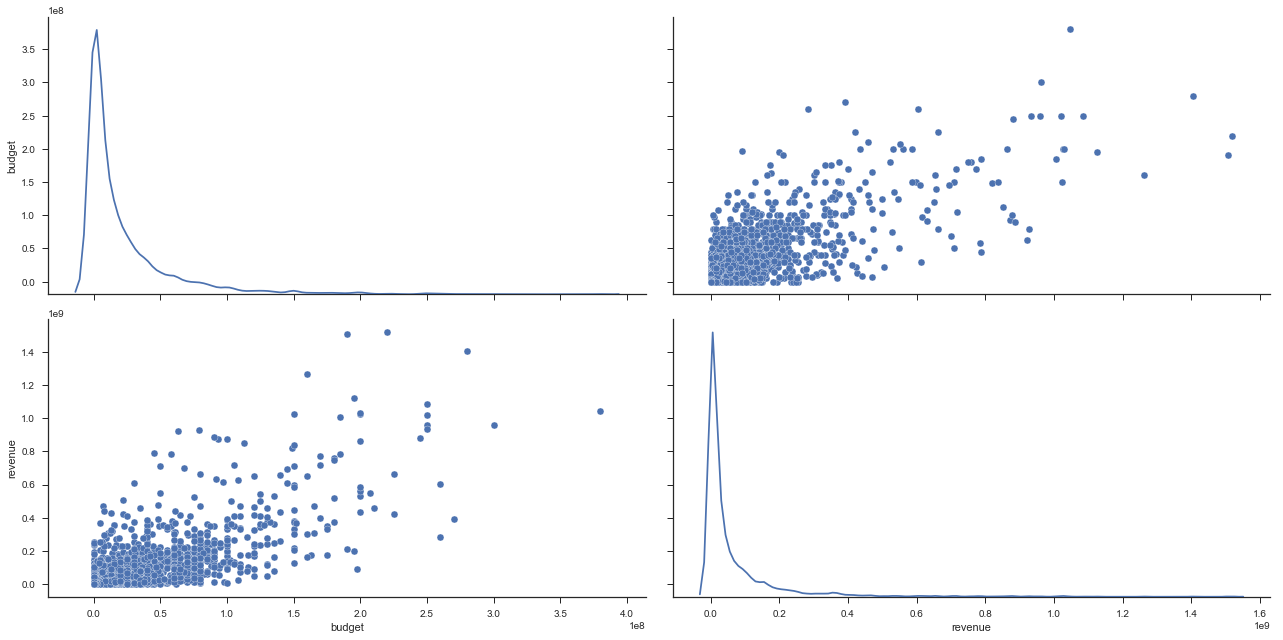

In [1862]:
sns.set(style="ticks")
ax = sns.pairplot(train_df[["budget", "revenue"]], size=4.5, aspect=2,   diag_kind= "kde")
plt.show()

As we would expect a higher budget leads to a higher revenue. Thus, more spending on the movie (not always) in general leads to higher Revenue. However, we still have not dealt with the problem of the budget values. Indeed, if we log the budget these values will result in an error:

In [1863]:
train_df["budget"] = np.log(train_df["budget"])
test_df["budget"] = np.log(test_df["budget"])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


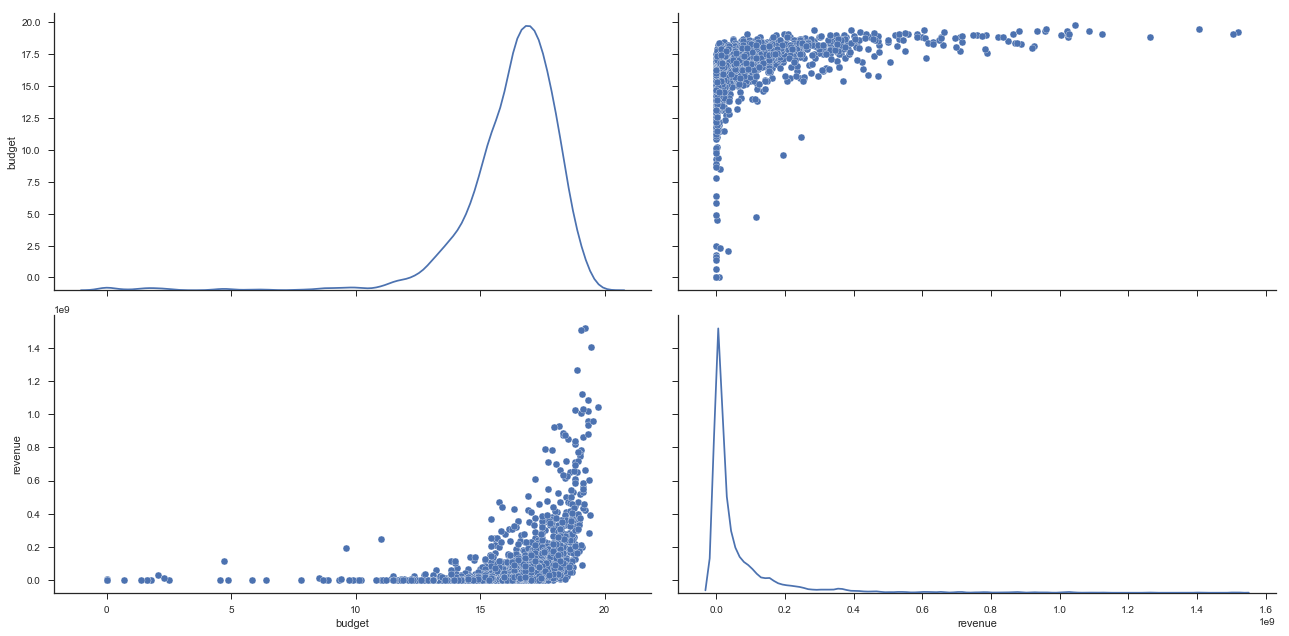

In [1864]:
sns.set(style="ticks")
ax = sns.pairplot(train_df[["budget", "revenue"]], size=4.5, aspect=2,   diag_kind= "kde")
plt.show()

In [1865]:
lst = []
for row in train_df["budget"]:
    if row == -np.inf:
        row = 0
        lst.append(row)
    else: 
        lst.append(row)
train_df["budget"] = lst

In [1866]:
lst = []
for row in test_df["budget"]:
    if row == -np.inf:
        row = 0
        lst.append(row)
    else: 
        lst.append(row)
test_df["budget"] = lst

In [1867]:
train_df["budget"].head()

0    16.454568
1    17.504390
2    15.009433
3    13.997832
4     0.000000
Name: budget, dtype: float64

Overall we decide to keep the log values of the budget, altough a lot of entries are stored as 0.

### 1.3 "genres"

In [1868]:
def genres_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace(' ','').replace("name", "").replace("id", "").replace(":", "")
    ll = str1.split(",")[1::2]
    return ll

train_df["genres"] = train_df.genres.apply(lambda elem: genres_preprocessing(elem))
test_df["genres"] = test_df.genres.apply(lambda elem: genres_preprocessing(elem))


In [1869]:
genre_per_movie = []
for row in train_df["genres"]:
    if len(row) == 0:
        row = "0-genere"
        genre_per_movie.append(row)
    elif len(row) == 1:
        row = "1-genere"
        genre_per_movie.append(row)
    elif len(row) == 2:
        row = "2-genere"
        genre_per_movie.append(row)
    elif len(row) == 3:
        row = "3-genere"
        genre_per_movie.append(row)
    elif len(row) == 4:
        row = "4-genere"
        genre_per_movie.append(row)
    elif len(row) == 5:
        row = "5-genere"
        genre_per_movie.append(row)
    else:
        row = "6-genere"
        genre_per_movie.append(row)

train_df["genre_count"] = genre_per_movie

In [1870]:
genre_per_movie = []
for row in test_df["genres"]:
    if len(row) == 0:
        row = "0-genere"
        genre_per_movie.append(row)
    elif len(row) == 1:
        row = "1-genere"
        genre_per_movie.append(row)
    elif len(row) == 2:
        row = "2-genere"
        genre_per_movie.append(row)
    elif len(row) == 3:
        row = "3-genere"
        genre_per_movie.append(row)
    elif len(row) == 4:
        row = "4-genere"
        genre_per_movie.append(row)
    elif len(row) == 5:
        row = "5-genere"
        genre_per_movie.append(row)
    else:
        row = "6-genere"
        genre_per_movie.append(row)

test_df["genre_count"] = genre_per_movie

In [1871]:
genere_order = ['0-genere', '1-genere', '2-genere', '3-genere', '4-genere','5-genere', '6-genere']

In [1872]:
train_df["genre_count"] = train_df["genre_count"].astype("category").cat.set_categories(genere_order, ordered=True)
train_df["genre_count"] = train_df['genre_count'].cat.codes

test_df["genre_count"] = test_df["genre_count"].astype("category").cat.set_categories(genere_order, ordered=True)
test_df["genre_count"] = test_df['genre_count'].cat.codes

In [1873]:
train_df["genre_count"].value_counts()

2    972
3    900
1    593
4    393
5    111
6     24
0      7
Name: genre_count, dtype: int64

After having created a categorial variable for generes we now let's look into the single elements for each genere row and try to one hot encode them in our dataset

In [1874]:
from sklearn.feature_extraction.text import CountVectorizer

In [1875]:
vect = CountVectorizer()
X = vect.fit_transform(train_df["genres"].str.join(' '))
train_df = train_df.join(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))

In [1876]:
vect = CountVectorizer()
X = vect.fit_transform(test_df["genres"].str.join(' '))
test_df = test_df.join(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))

In [1877]:
train_df.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,history,horror,music,mystery,romance,sciencefiction,thriller,tvmovie,war,western
0,1,1,16.454568,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,0
1,2,1,17.504390,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,1,0,0,0,0,0
2,3,0,15.009433,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,0


In [1878]:
train_df = train_df.drop(["genres"], 1)
test_df = test_df.drop(["genres"], 1)

### 1.4 "homepage"

In [1879]:
print(f"The column has {train_df['homepage'].unique().shape} total categories")
print(f"The column has {train_df['homepage'].isnull().sum()} missing rows")
print(f"{train_df['homepage'].value_counts().max()/len(train_df['homepage'])} of the column is composed by one value")

The column has (942,) total categories
The column has 2054 missing rows
0.0013333333333333333 of the column is composed by one value


We decide to convert the column into a binary split.

In [1880]:
lst = []
for row in train_df["homepage"]:
    if str(type(row)) == "<class 'float'>":
        row = 0
        lst.append(row)
    else:
        row = 1
        lst.append(row)
lst = pd.Series(lst)
train_df["has_homepage"] = lst 

In [1881]:
lst = []
for row in test_df["homepage"]:
    if str(type(row)) == "<class 'float'>":
        row = 0
        lst.append(row)
    else:
        row = 1
        lst.append(row)
lst = pd.Series(lst)
test_df["has_homepage"] = lst 

In [1882]:
train_df = train_df.drop(["homepage"], 1)
test_df = test_df.drop(["homepage"], 1)

### 1.5 "original_language"

In [1883]:
train_df["original_language"].value_counts().head()

en    2575
fr      78
ru      47
es      43
hi      42
Name: original_language, dtype: int64

In [1884]:
print(f"The column has {train_df['original_language'].unique().shape} total categories")
print(f"The column has {train_df['original_language'].isnull().sum()} missing rows")
print(f"{train_df['original_language'].value_counts().max()/len(train_df['original_language'])} of the column is composed by one value")

The column has (36,) total categories
The column has 0 missing rows
0.8583333333333333 of the column is composed by one value


Altough using a binary distinguisher between english being the main language and the rest may seem redundant is we do encode the column we still do it to ge our model more diverified points of view.


In [1885]:
main_is_english = []
for lang in train_df["original_language"]:
    if lang == "en":
        lang = 1
        main_is_english.append(lang)
    else:
        lang = 0
        main_is_english.append(lang)

train_df["main_is_english"] = main_is_english

In [1886]:
main_is_english = []
for lang in test_df["original_language"]:
    if lang == "en":
        lang = 1
        main_is_english.append(lang)
    else:
        lang = 0
        main_is_english.append(lang)

test_df["main_is_english"] = main_is_english

Now we encode the column

In [1887]:
train_df["original_language"] = train_df["original_language"].astype("category").cat.codes
test_df["original_language"] = test_df["original_language"].astype("category").cat.codes

In [1888]:
train_df["original_language"].value_counts().head()

7     2575
11      78
27      47
8       43
13      42
Name: original_language, dtype: int64

### 1.6 "original_title"

In [1889]:
s =  train_df["original_title"].value_counts() == 2
d = s.reset_index()
double_title = d[d["original_title"] == True]["index"]
lst = []
for row in train_df["original_title"].isin(double_title):
    if row == True:
        row = 1
        lst.append(row)
    else:
        row = 0
        lst.append(row)
train_df["title_appears_twice"] = lst

In [1890]:
s =  test_df["original_title"].value_counts() == 2
d = s.reset_index()
double_title = d[d["original_title"] == True]["index"]
lst = []
for row in test_df["original_title"].isin(double_title):
    if row == True:
        row = 1
        lst.append(row)
    else:
        row = 0
        lst.append(row)
test_df["title_appears_twice"] = lst

In [1891]:
print(f"The column has {train_df['original_title'].unique().shape} total categories")
print(f"The column has {train_df['original_title'].isnull().sum()} missing rows")
print(f"{train_df['original_title'].value_counts().max()/len(train_df['original_title'])} of the column is composed by one value")

The column has (2975,) total categories
The column has 0 missing rows
0.0006666666666666666 of the column is composed by one value


In [1892]:
train_df = train_df.drop(["original_title"],1)
test_df = test_df.drop(["original_title"],1)

### 1.7 "overview"

In [1893]:
train_df["overview"].value_counts().head(1)

Ast√©rix and Ob√©lix have to win the Olympic Games in order to help their friend Alafolix marry Princess Irina (portrayed by supermodel Vanessa Hessler). Brutus (Beno√Æt Poelvoorde) uses every trick in the book to have his own team win the game, and get rid of his father Julius Caesar (Alain Delon) in the process.    1
Name: overview, dtype: int64

In [1894]:
print(f"The column has {train_df['overview'].unique().shape} total categories")
print(f"The column has {train_df['overview'].isnull().sum()} missing rows")
print(f"{train_df['overview'].value_counts().max()/len(train_df['overview'])} of the column is composed by one value")

The column has (2993,) total categories
The column has 8 missing rows
0.0003333333333333333 of the column is composed by one value


Although the column is composed by short-descriptions of the actual movie, we might be able to process this data to capture some sort of interaction with the dependent variable.

First, let's deal with the nan values.

In [1895]:
train_df["overview"] = train_df["overview"].fillna(0)
test_df["overview"] = test_df["overview"].fillna(0)
print(f"The column has {train_df['overview'].isnull().sum()} missing rows")

The column has 0 missing rows


Thanks to a simple loop iteration we are able to count the exact amount of characters that has been used in the description (without blank spaces). We are interested in capturing whether a longer string increases consumer expectations and consequently raises sales. 

In [1896]:
lst = []
for row in train_df["overview"]:
    if str(type(row)) == "<class 'str'>":
        row = row.strip()
        row = re.sub('[^A-Za-z0-9]+', '', row)
        row = len(row)
        lst.append(row)
    else:
        row = 0
        lst.append(row)
train_df["overview"] = lst

In [1897]:
lst = []
for row in test_df["overview"]:
    if str(type(row)) == "<class 'str'>":
        row = row.strip()
        row = re.sub('[^A-Za-z0-9]+', '', row)
        row = len(row)
        lst.append(row)
    else:
        row = 0
        lst.append(row)
test_df["overview"] = lst

In [1898]:
train_df["overview"].value_counts().head()

136    18
169    17
114    16
258    16
263    16
Name: overview, dtype: int64

In [1899]:
print(f"The column has {train_df['overview'].unique().shape} total categories")
print(f"The column has {train_df['overview'].isnull().sum()} missing rows")
print(f"{train_df['overview'].value_counts().max()/len(train_df['overview'])} of the column is composed by one value")

The column has (553,) total categories
The column has 0 missing rows
0.006 of the column is composed by one value


We reduced the variety in the data to 1/6 of its initial value and are now able to use the column as an independent predictor for our model. Now we need to bin the numbers. Let's have a look at the distribution.

The maxium length of the desciption is 808
The minimum length of the desciption is 0


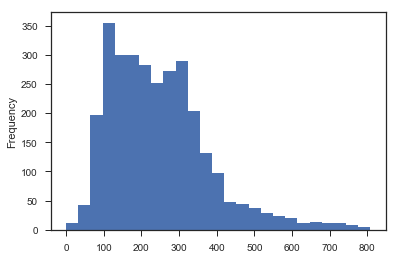

In [1900]:
train_df['overview'].plot.hist(bins = 25)
print(f"The maxium length of the desciption is {train_df['overview'].max()}")
print(f"The minimum length of the desciption is {train_df['overview'].min()}")

We decide to use 8 bins to group this data

In [1901]:
lst = []
for row in train_df['overview']:
    if row <= 100:
        row = "0-100"
        lst.append(row)
    elif row > 100 and row <= 200:
        row = "100-200"
        lst.append(row)
    elif row >200 and row <= 300:
        row = "200-300"
        lst.append(row)
    elif row >300 and row <= 400:
        row = "300-400"
        lst.append(row)
    elif row >400 and row <= 500:
        row = "400-500"
        lst.append(row)
    elif row >500 and row <= 600:
        row = "500-600"
        lst.append(row)
    elif row >600 and row <= 700:
        row = "600-700"
        lst.append(row)
    else:
        row = ">700"
        lst.append(row)
train_df['overview'] = lst

In [1902]:
lst = []
for row in test_df['overview']:
    if row <= 100:
        row = "0-100"
        lst.append(row)
    elif row > 100 and row <= 200:
        row = "100-200"
        lst.append(row)
    elif row >200 and row <= 300:
        row = "200-300"
        lst.append(row)
    elif row >300 and row <= 400:
        row = "300-400"
        lst.append(row)
    elif row >400 and row <= 500:
        row = "400-500"
        lst.append(row)
    elif row >500 and row <= 600:
        row = "500-600"
        lst.append(row)
    elif row >600 and row <= 700:
        row = "600-700"
        lst.append(row)
    else:
        row = ">700"
        lst.append(row)
test_df['overview'] = lst

In [1903]:
train_df['overview'].value_counts()

100-200    987
200-300    812
300-400    591
0-100      290
400-500    171
500-600     77
600-700     40
>700        32
Name: overview, dtype: int64

In [1904]:
print(f"The column has {train_df['overview'].unique().shape} total categories")
print(f"The column has {train_df['overview'].isnull().sum()} missing rows")
print(f"{train_df['overview'].value_counts().max()/len(train_df['overview'])} of the column is composed by one value")

The column has (8,) total categories
The column has 0 missing rows
0.329 of the column is composed by one value


In [1905]:
overview_order = ['0-100', '100-200', '200-300','300-400', '400-500',  '500-600',  '600-700', '>700']

In [1906]:
train_df["overview"] = train_df["overview"].astype("category").cat.set_categories(overview_order, ordered=True)
train_df["overview"] = train_df['overview'].astype("category").cat.codes

test_df["overview"] = test_df["overview"].astype("category").cat.set_categories(overview_order, ordered=True)
test_df["overview"] = test_df['overview'].astype("category").cat.codes

### 1.8 "imdb_id"

In [1907]:
print(f"The column has {train_df['imdb_id'].unique().shape} total categories")
print(f"The column has {train_df['imdb_id'].isnull().sum()} missing rows")
print(f"{train_df['imdb_id'].value_counts().max()/len(train_df['imdb_id'])} of the column is composed by one value")

The column has (3000,) total categories
The column has 0 missing rows
0.0003333333333333333 of the column is composed by one value


If this was a real-life project one could use the imdb_id to retrive valuabe insights from the [IMDB API](https://developers.themoviedb.org/3/find). Nonetheless, for the purpose of this competition we deem that this column does not hold any valuable data for our model.

In [1908]:
train_df = train_df.drop(["imdb_id"],1)
test_df = test_df.drop(["imdb_id"],1)

### 1.9 "poster_path"

In [1909]:
print(f"The column has {train_df['poster_path'].unique().shape} total categories")
print(f"The column has {train_df['poster_path'].isnull().sum()} missing rows")
print(f"{train_df['poster_path'].value_counts().max()/len(train_df['poster_path'])} of the column is composed by one value")

The column has (3000,) total categories
The column has 1 missing rows
0.0003333333333333333 of the column is composed by one value


We decide to drop this column. 

In [1910]:
train_df = train_df.drop(["poster_path"],1)
test_df = test_df.drop(["poster_path"],1)

### 1.11 "production_companies"

In [1911]:
print(f"The column has {train_df['production_companies'].unique().shape} total categories")
print(f"The column has {train_df['production_companies'].isnull().sum()} missing rows")
print(f"{train_df['production_companies'].value_counts().max()/len(train_df['production_companies'])} of the column is composed by one value")

The column has (2384,) total categories
The column has 156 missing rows
0.017 of the column is composed by one value


In [1912]:
def production_companies_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("id", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_companies_processed"] = train_df.production_companies.apply(lambda elem: production_companies_preprocessing(elem))
test_df["production_companies_processed"] = test_df.production_companies.apply(lambda elem: production_companies_preprocessing(elem))

In [1913]:
count_comp = []
for row in train_df["production_companies_processed"]:
    if row[0] != "nan" and len(row) == 1 :
        row = "1-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 2:
        row = "2-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 3:
        row = "3-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 4:
        row = "4-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 5:
        row = "5-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 6:
        row = "6-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 7:
        row = "7-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 8:
        row = "8-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 9:
        row = "9-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 10:
        row = "10-companies"
        count_comp.append(row)
    elif row[0] == "nan":
        row = "0-companies"
        count_comp.append(row)
    else:
        row = ">10-companies"
        count_comp.append(row)

train_df["production_companies_count"] = count_comp

In [1914]:
count_comp = []
for row in test_df["production_companies_processed"]:
    if row[0] != "nan" and len(row) == 1 :
        row = "1-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 2:
        row = "2-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 3:
        row = "3-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 4:
        row = "4-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 5:
        row = "5-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 6:
        row = "6-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 7:
        row = "7-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 8:
        row = "8-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 9:
        row = "9-companies"
        count_comp.append(row)
    elif row[0] != "nan" and len(row) == 10:
        row = "10-companies"
        count_comp.append(row)
    elif row[0] == "nan":
        row = "0-companies"
        count_comp.append(row)
    else:
        row = ">10-companies"
        count_comp.append(row)

test_df["production_companies_count"] = count_comp

In [1915]:
train_df["production_companies_count"].value_counts()

1-companies      774
2-companies      727
3-companies      578
4-companies      322
5-companies      161
0-companies      156
6-companies      122
7-companies       62
8-companies       42
9-companies       32
>10-companies     18
10-companies       6
Name: production_companies_count, dtype: int64

In [1916]:
order_prod_count = [ '0-companies',
 '1-companies',
 '2-companies',
 '3-companies',
 '4-companies',
 '5-companies',
 '6-companies',
 '7-companies',
 '8-companies',
 '9-companies',
 '10-companies', 
 '>10-companies']

In [1917]:
train_df["production_companies_count"] = train_df["production_companies_count"].astype("category").cat.set_categories(order_prod_count, ordered=True)
train_df["production_companies_count"] = train_df['production_companies_count'].astype("category").cat.codes

test_df["production_companies_count"] = test_df["production_companies_count"].astype("category").cat.set_categories(order_prod_count, ordered=True)
test_df["production_companies_count"] = test_df['production_companies_count'].astype("category").cat.codes

In [1918]:
companies = []
for row in train_df["production_companies_processed"]:
    if row[0] == "nan":
        row = 0
        companies.append(row)
    else:
        row = 1
        companies.append(row)
train_df["has_production_company"] = companies

In [1919]:
companies = []
for row in test_df["production_companies_processed"]:
    if row[0] == "nan":
        row = 0
        companies.append(row)
    else:
        row = 1
        companies.append(row)
test_df["has_production_company"] = companies

In [1920]:
train_df = train_df.drop(["production_companies","production_companies_processed"],1)
test_df = test_df.drop(["production_companies","production_companies_processed"],1)

### 1.12 Production Countries

In [1921]:
print(f"The column has {train_df['production_countries'].unique().shape} total categories")
print(f"The column has {train_df['production_countries'].isnull().sum()} missing rows")
print(f"{train_df['production_countries'].value_counts().max()/len(train_df['production_countries'])} of the column is composed by one value")

The column has (322,) total categories
The column has 55 missing rows
0.584 of the column is composed by one value


In [1922]:
def production_countries_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("iso_3166_1", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_countries_processed"] = train_df.production_countries.fillna("NaN").apply(lambda elem: production_countries_preprocessing(elem))
test_df["production_countries_processed"] = test_df.production_countries.fillna("NaN").apply(lambda elem: production_countries_preprocessing(elem))

In [1923]:
count_comp = []
for row in train_df["production_countries_processed"]:
    if row[0] != "NaN" and len(row) == 1 :
        row = "1-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 2:
        row = "2-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 3:
        row = "3-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 4:
        row = "4-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 5:
        row = "5-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 6:
        row = "6-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 7:
        row = "7-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 8:
        row = "8-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 9:
        row = "9-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 10:
        row = "10-country"
        count_comp.append(row)
    elif row[0] == "NaN":
        row = "0-country"
        count_comp.append(row)
    else:
        row = "8-country"
        count_comp.append(row)

train_df["production_countries_count"] = count_comp

In [1924]:
count_comp = []
for row in test_df["production_countries_processed"]:
    if row[0] != "NaN" and len(row) == 1 :
        row = "1-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 2:
        row = "2-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 3:
        row = "3-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 4:
        row = "4-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 5:
        row = "5-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 6:
        row = "6-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 7:
        row = "7-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 8:
        row = "8-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 9:
        row = "9-country"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 10:
        row = "10-country"
        count_comp.append(row)
    elif row[0] == "NaN":
        row = "0-country"
        count_comp.append(row)
    else:
        row = "8-country"
        count_comp.append(row)

test_df["production_countries_count"] = count_comp

In [1925]:
train_df["production_countries_count"].value_counts()

1-country    2222
2-country     525
3-country     116
4-country      57
0-country      55
5-country      21
6-country       3
8-country       1
Name: production_countries_count, dtype: int64

In [1926]:
order_prod_country = [ '0-country',
 '1-country',
 '2-country',
 '3-country',
 '4-country',
 '5-country',
 '6-country',
 '7-country',
 '8-country']

In [1927]:
train_df["production_countries_count"] = train_df["production_countries_count"].astype("category").cat.set_categories(order_prod_country, ordered=True)
train_df["production_countries_count"] = train_df['production_countries_count'].astype("category").cat.codes

test_df["production_countries_count"] = test_df["production_countries_count"].astype("category").cat.set_categories(order_prod_country, ordered=True)
test_df["production_countries_count"] = test_df['production_countries_count'].astype("category").cat.codes

In [1928]:
train_df = train_df.drop(["production_countries", "production_countries_processed" ],1)
test_df = test_df.drop(["production_countries", "production_countries_processed" ],1)

### 1.13 "release date" 

In [1929]:
print(f"The column has {train_df['release_date'].unique().shape} total categories")
print(f"The column has {train_df['release_date'].isnull().sum()} missing rows")
print(f"{train_df['release_date'].value_counts().max()/len(train_df['release_date'])} of the column is composed by one value")

The column has (2398,) total categories
The column has 0 missing rows
0.0016666666666666668 of the column is composed by one value


Thanks to fast.ai we can easily transform release_date and to draw some interesting datapoints to form new columns.

In [1930]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [1931]:
add_datepart(train_df, 'release_date')
add_datepart(test_df, 'release_date')

In [1932]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'original_language',
       'overview', 'popularity', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'budget_is_zero', 'genre_count', 'action', 'adventure', 'animation',
       'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy',
       'foreign', 'history', 'horror', 'music', 'mystery', 'romance',
       'sciencefiction', 'thriller', 'tvmovie', 'war', 'western',
       'has_homepage', 'main_is_english', 'title_appears_twice',
       'production_companies_count', 'has_production_company',
       'production_countries_count', 'release_Year', 'release_Month',
       'release_Week', 'release_Day', 'release_Dayofweek', 'release_Dayofyear',
       'release_Is_month_end', 'release_Is_month_start',
       'release_Is_quarter_end', 'release_Is_quarter_start',
       'release_Is_year_end', 'release_Is_year_start', 'release_Elapsed'],
      dtype='object')

In [1933]:
dt = train_df.columns.isin(test_df.columns) == False
dt = pd.Series(dt)
dt[dt == True]

14    True
34    True
dtype: bool

In [1934]:
train_df.columns[28]

'horror'

We noticed that thanks to the helper function created by fast.ai we were able to capture valuable information about the date.

### 1.14 "runtime"

In [1935]:
train_df['runtime'].value_counts().head()

90.0     100
100.0     99
105.0     91
95.0      89
98.0      85
Name: runtime, dtype: int64

In [1936]:
print(f"The column has {train_df['runtime'].unique().shape} total categories")
print(f"The column has {train_df['runtime'].isnull().sum()} missing rows")
print(f"{train_df['runtime'].value_counts().max()/len(train_df['runtime'])} of the column is composed by one value")

The column has (140,) total categories
The column has 2 missing rows
0.03333333333333333 of the column is composed by one value


We notice that there are two missing values. Let's look at them in more detail

It looks like both columns have quiet some missing data. Thus, we decide to remove these two columns from our training data.

In [1937]:
train_df["runtime"] = train_df["runtime"].fillna(0)
test_df["runtime"] = test_df['runtime'].fillna(0)

In [1938]:
print(f"The column has {train_df['runtime'].isnull().sum()} missing rows")

The column has 0 missing rows


### 1.15 "spoken_languages"

In [1939]:
print(f"The column has {train_df['spoken_languages'].unique().shape} total categories")
print(f"The column has {train_df['spoken_languages'].isnull().sum()} missing values")
print(f"{train_df['spoken_languages'].value_counts().max()/len(train_df['spoken_languages'])} of the column is composed by one value")

The column has (402,) total categories
The column has 20 missing values
0.6056666666666667 of the column is composed by one value


In [1940]:
def language_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("iso_3166_1", "").replace(":", "").replace("\'", "").replace("iso_639_1", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["spoken_languages_processed"] = train_df.spoken_languages.fillna("NaN").apply(lambda elem: language_preprocessing(elem))
test_df["spoken_languages_processed"] = test_df.spoken_languages.fillna("NaN").apply(lambda elem: language_preprocessing(elem))

In [1941]:
train_df["spoken_languages_processed"].head()

0        [en]
1        [en]
2        [en]
3    [en, hi]
4        [ko]
Name: spoken_languages_processed, dtype: object

In [1942]:
count_comp = []
for row in train_df["spoken_languages_processed"]:
    if row[0] != "NaN" and len(row) == 1 :
        row = "1-language"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 2:
        row = "2-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 3:
        row = "3-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 4:
        row = "4-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 5:
        row = "5-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 6:
        row = "6-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 7:
        row = "7-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 8:
        row = "8-languages"
        count_comp.append(row)
    elif row[0] == "NaN":
        row = "0-languages"
        count_comp.append(row)
    else:
        row = ">8-languages"
        count_comp.append(row)

train_df["spoken_languages_count"] = count_comp

In [1943]:
count_comp = []
for row in test_df["spoken_languages_processed"]:
    if row[0] != "NaN" and len(row) == 1 :
        row = "1-language"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 2:
        row = "2-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 3:
        row = "3-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 4:
        row = "4-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 5:
        row = "5-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 6:
        row = "6-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 7:
        row = "7-languages"
        count_comp.append(row)
    elif row[0] != "NaN" and len(row) == 8:
        row = "8-languages"
        count_comp.append(row)
    elif row[0] == "NaN":
        row = "0-languages"
        count_comp.append(row)
    else:
        row = ">8-languages"
        count_comp.append(row)

test_df["spoken_languages_count"] = count_comp

In [1944]:
order_prod_lang = [  '0-languages',
 '1-language',
 '2-languages',
 '3-languages',
 '4-languages',
 '5-languages',
 '6-languages',
 '7-languages',
 '8-languages',
 '>8-languages']

In [1945]:
train_df["spoken_languages_count"] = train_df["spoken_languages_count"].astype("category").cat.set_categories(order_prod_lang, ordered=True)
train_df["spoken_languages_count"] = train_df['spoken_languages_count'].astype("category").cat.codes

test_df["spoken_languages_count"] = test_df["spoken_languages_count"].astype("category").cat.set_categories(order_prod_lang, ordered=True)
test_df["spoken_languages_count"] = test_df['spoken_languages_count'].astype("category").cat.codes


We drop the other column.

In [1946]:
train_df = train_df.drop(['spoken_languages',"spoken_languages_processed"],1)
test_df = test_df.drop(['spoken_languages',"spoken_languages_processed"],1)

### 1.16 "status"

In [1947]:
train_df["status"].value_counts().head()

Released    2996
Rumored        4
Name: status, dtype: int64

In [1948]:
print(f"The column has {train_df['status'].unique().shape} total categories")
print(f"The column has {train_df['status'].isnull().sum()} missing values")
print(f"{train_df['status'].value_counts().max()/len(train_df['status'])} of the column is composed by one value")

The column has (2,) total categories
The column has 0 missing values
0.9986666666666667 of the column is composed by one value


In [1949]:
lst = []
for row in train_df["status"]:
    if row == "Released":
        row = 1
        lst.append(row)
    else:
        row = 0
        lst.append(row)
train_df["status"] = lst

In [1950]:
lst = []
for row in test_df["status"]:
    if row == "Released":
        row = 1
        lst.append(row)
    else:
        row = 0
        lst.append(row)
test_df["status"] = lst

### 1.17 "tagline"

In [1951]:
train_df["tagline"].value_counts().head()

Based on a true story.                             3
Who is John Galt?                                  2
Eight legs, two fangs, and an attitude.            1
The system is perfect until it comes after you.    1
6 reels of Joy.                                    1
Name: tagline, dtype: int64

In [1952]:
print(f"The column has {train_df['tagline'].unique().shape} total categories")
print(f"The column has {train_df['tagline'].isnull().sum()} missing values")
print(f"{train_df['tagline'].value_counts().max()/len(train_df['tagline'])} of the column is composed by one value")

The column has (2401,) total categories
The column has 597 missing values
0.001 of the column is composed by one value


In [1953]:
lst = []
for row in train_df["tagline"]:
    if str(type(row)) == "<class 'str'>":
        row = row.strip()
        row = re.sub('[^A-Za-z0-9]+', '', row)
        row = len(row)
        lst.append(row)
    else:
        row = 0
        lst.append(row)
train_df["tagline"] = lst

In [1954]:
lst = []
for row in test_df["tagline"]:
    if str(type(row)) == "<class 'str'>":
        row = row.strip()
        row = re.sub('[^A-Za-z0-9]+', '', row)
        row = len(row)
        lst.append(row)
    else:
        row = 0
        lst.append(row)
test_df["tagline"] = lst

The maxium length of the desciption is 181
The minimum length of the desciption is 0


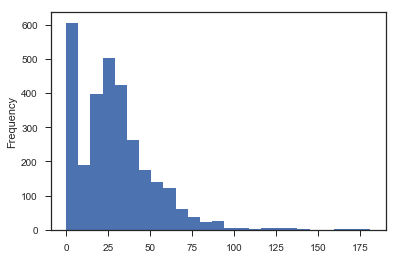

In [1955]:
train_df['tagline'].plot.hist(bins = 25)
print(f"The maxium length of the desciption is {train_df['tagline'].max()}")
print(f"The minimum length of the desciption is {train_df['tagline'].min()}")

In [1956]:
lst = []
for row in train_df['tagline']:
    if row <= 20:
        row = "0-10"
        lst.append(row)
    elif row > 20 and row <= 40:
        row = "20-40"
        lst.append(row)
    elif row >40 and row <= 60:
        row = "40-60"
        lst.append(row)
    elif row >60 and row <= 80:
        row = "60-80"
        lst.append(row)
    elif row >80 and row <= 100:
        row = "80-100"
        lst.append(row)
    elif row >100 and row <= 120:
        row = "100-120"
        lst.append(row)
    elif row >120 and row <= 140:
        row = "120-140"
        lst.append(row)
    elif row >140 and row <= 160:
        row = "140-160"
        lst.append(row)
    else:
        row = ">160"
        lst.append(row)
train_df['tagline'] = lst

In [1957]:
lst = []
for row in test_df['tagline']:
    if row <= 20:
        row = "0-10"
        lst.append(row)
    elif row > 20 and row <= 40:
        row = "20-40"
        lst.append(row)
    elif row >40 and row <= 60:
        row = "40-60"
        lst.append(row)
    elif row >60 and row <= 80:
        row = "60-80"
        lst.append(row)
    elif row >80 and row <= 100:
        row = "80-100"
        lst.append(row)
    elif row >100 and row <= 120:
        row = "100-120"
        lst.append(row)
    elif row >120 and row <= 140:
        row = "120-140"
        lst.append(row)
    elif row >140 and row <= 160:
        row = "140-160"
        lst.append(row)
    else:
        row = ">160"
        lst.append(row)
test_df['tagline'] = lst

In [1958]:
print(f"The column has {train_df['tagline'].unique().shape} total categories")
print(f"The column has {train_df['tagline'].isnull().sum()} missing values")
print(f"{train_df['tagline'].value_counts().max()/len(train_df['tagline'])} of the column is composed by one value")

The column has (8,) total categories
The column has 0 missing values
0.37866666666666665 of the column is composed by one value


In [1959]:
tag_order = ['0-10', '20-40','40-60', '60-80', '80-100', '100-120', '120-140', '>160']

In [1960]:
train_df["tagline"] = train_df["tagline"].astype("category").cat.set_categories(tag_order, ordered=True)
train_df["tagline"] = train_df['tagline'].astype("category").cat.codes


test_df["tagline"] = test_df["tagline"].astype("category").cat.set_categories(tag_order, ordered=True)
test_df["tagline"] = test_df['tagline'].astype("category").cat.codes

# Don't forget these 5 columns

In [1961]:
train_df = train_df.drop(["Keywords","title", "cast", "crew","id"],1)
test_df = test_df.drop(["Keywords", "title","cast", "crew"],1)

# Model

In [1962]:
train_df.shape, test_df.shape

((3000, 51), (4398, 50))

We notice a discrpeancy between the columns of the two datasets. Let's find out why.

In [1963]:
dt = train_df.columns.isin(test_df.columns) == False
dt = pd.Series(dt)
dt[dt == True]

8     True
28    True
dtype: bool

In [1964]:
train_df.columns[8], train_df.columns[28]

('revenue', 'tvmovie')

In [1965]:
train_df[train_df["tvmovie"] == True]

,belongs_to_collection,budget,original_language,overview,popularity,runtime,status,tagline,revenue,budget_is_zero,...,release_Dayofweek,release_Dayofyear,release_Is_month_end,release_Is_month_start,release_Is_quarter_end,release_Is_quarter_start,release_Is_year_end,release_Is_year_start,release_Elapsed,spoken_languages_count
1693,0,15.424948,7,1,5.147819,89.0,1,1,42000000,0,...,6,91,True,False,True,False,False,False,828230400,1


Eventually, we found that one row in train_df had a row with a feature that is not found in the test_df. We fix this by dropping the row and the column.

In [1966]:
train_df = train_df[train_df["tvmovie"] == False].drop(["tvmovie"], 1)

In [1967]:
train_df.shape

(2999, 50)

In [1968]:
train_df["revenue"] = np.log(train_df["revenue"])

# Hyperparamter Tuning

Before we scale the model we are going to tune the hyperparamters by using 33% of the dataset validation set.

In [1969]:
from sklearn.model_selection import train_test_split

In [1970]:
X = train_df.drop(["revenue"],1)
y = train_df["revenue"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2009, 49), (2009,), (990, 49), (990,))

In [1971]:
from sklearn.neighbors import KNeighborsRegressor

In [1972]:
m = RandomForestRegressor(n_jobs = -1,random_state= 1)
m.fit(X_train, y_train)
print_score(m)

[1.0032786751258247, 2.192242757402596, 0.8983979305499307, 0.4324131057208035]


In [1973]:
estimators = [9,12,14,16,18,20,23,25,28,31,34,37,50,200,1000]
for i in estimators:
    m = RandomForestRegressor(n_jobs = -1, n_estimators= i,random_state= 1)
    m.fit(X_train, y_train)
    print(i, print_score(m))

[1.0241622539366044, 2.209268823510351, 0.8941241469682262, 0.4235625358450421]
9 None
[0.9825381971074992, 2.155467220629318, 0.9025552878303387, 0.4512962650413911]
12 None
[0.9546791683926777, 2.13038158771225, 0.9080028690703127, 0.46399372875181266]
14 None
[0.9466888775954231, 2.110481995334939, 0.9095363845611268, 0.4739604785052295]
16 None
[0.930006990831931, 2.1101071399032234, 0.9126964673309317, 0.47414732801204607]
18 None
[0.906980129357439, 2.1035793238190146, 0.9169661957372031, 0.4773958454179422]
20 None
[0.8996934737386686, 2.10457298981975, 0.918295019343928, 0.4769020046356143]
23 None
[0.901224056944517, 2.1021291712595414, 0.918016785368783, 0.4781161363247928]
25 None
[0.8882555573393468, 2.087917186046956, 0.9203592653040625, 0.48514894245895357]
28 None
[0.8761498397179905, 2.092297454465076, 0.9225152630776138, 0.48298645111667293]
31 None
[0.8744524594041551, 2.0870392675412477, 0.9228151973173834, 0.4855818161832339]
34 None
[0.8656495363761698, 2.081697623

We have a clear overfitting problem. Howevwer, we also notice that more richness dictated by the amount of trees decreases the error margin. So far the lowest error has been achieved between 20 - 50 trees. Let's try trimming down the specturm.

In [1974]:
estimators = np.arange(20, 50, 2)
for i in estimators:
    m = RandomForestRegressor(n_jobs = -1, n_estimators= i,random_state= 1)
    m.fit(X_train, y_train)
    print(i, print_score(m))

[0.9069801293574389, 2.1035793238190146, 0.9169661957372031, 0.47739584541794233]
20 None
[0.9004076363374942, 2.1040270876691194, 0.9181652555922966, 0.47717334070853834]
22 None
[0.8988847673517926, 2.10705240123125, 0.9184418374438553, 0.4756687481671259]
24 None
[0.8953946094522989, 2.0923514427869105, 0.9190739501672861, 0.4829597693903911]
26 None
[0.8882555573393467, 2.087917186046956, 0.9203592653040625, 0.48514894245895357]
28 None
[0.8813186204211688, 2.092724242154881, 0.921598335493998, 0.48277550833479965]
30 None
[0.878181359092545, 2.090413240067471, 0.9221555204134707, 0.4839172229145069]
32 None
[0.874452459404155, 2.0870392675412477, 0.9228151973173834, 0.4855818161832339]
34 None
[0.8712325479555583, 2.0813977650899043, 0.9233825710183863, 0.488359118124698]
36 None
[0.8622496129850272, 2.084403365090962, 0.9249543700745092, 0.4868804020748393]
38 None
[0.8589167669074893, 2.0855514925766743, 0.925533395323938, 0.48631497508063326]
40 None
[0.8597079025313723, 2.0872

In [1975]:
preds = np.stack([t.predict(X_test) for t in m.estimators_])

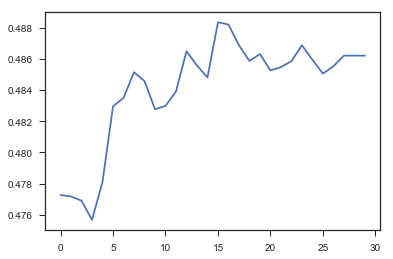

In [1976]:
plt.plot([metrics.r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in np.arange(20, 50, 1)]);

Overall we conclude that the best predictions are done with 15-30 trees

In [1977]:
m = RandomForestRegressor(n_jobs = -1, n_estimators= 20, random_state= 1)
m.fit(X_train, y_train)
print_score(m)

[0.906980129357439, 2.1035793238190146, 0.9169661957372031, 0.47739584541794233]


Now that we have seen the amount of the trees let's try to tune some other hyperparamters to see if we can further overcome overfitting.

In [1978]:
max_depth = list(range(1,20))
for i in max_depth:
    m = RandomForestRegressor(n_jobs = -1, n_estimators= 20,max_depth= i,random_state= 1)
    m.fit(X_train, y_train)
    print(i, print_score(m))

[2.6115794850287535, 2.409925026572228, 0.31156032969123626, 0.31409789679513045]
1 None
[2.404095234944515, 2.2217799455936613, 0.41660496803468006, 0.41701530184556423]
2 None
[2.2719715340894653, 2.1121749033632797, 0.4789670814779732, 0.47311622235911366]
3 None
[2.1397805283750335, 2.085087157514298, 0.5378341481079585, 0.4865436871658744]
4 None
[2.0075486650193435, 2.0601371604633045, 0.593190061070011, 0.4987581284716068]
5 None
[1.8506736749637207, 2.0521677653004406, 0.6542843133341268, 0.5026286166277839]
6 None
[1.6835803879768436, 2.0650512420582086, 0.7138939067278369, 0.4963640343378588]
7 None
[1.522894257796825, 2.0667599668331222, 0.7659013606655052, 0.4955302232675704]
8 None
[1.382422613906206, 2.0629304519770475, 0.8070960813135503, 0.4973979628629952]
9 None
[1.252279002909702, 2.075809639300458, 0.8417070442051312, 0.49110273166001867]
10 None
[1.1552548644998486, 2.087048144326307, 0.8652852954510576, 0.48557744023360117]
11 None
[1.0677456118016269, 2.089554292

This time we notice that altough we are dynamically testing for different depths the predictions of our model are more or less the same. Thus, we decided to try tuning a different hyperparamter as this one yields no apparent benefit.

In [1979]:
min_samples_leaves = list(range(1,10))
for i in min_samples_leaves:
    m = RandomForestRegressor(n_jobs = -1, n_estimators= 20, min_samples_leaf= i, random_state= 1)
    m.fit(X_train, y_train)
    print(i, print_score(m))

[0.906980129357439, 2.1035793238190146, 0.9169661957372031, 0.4773958454179422]
1 None
[1.1430306273581665, 2.0752378477140683, 0.8681211577111834, 0.4913830493678835]
2 None
[1.3217562511576835, 2.060646935782493, 0.8236554113872117, 0.4985100359135892]
3 None
[1.455417952754734, 2.051778763505453, 0.78618663596579, 0.502817158740798]
4 None
[1.5557277162764156, 2.0430369202444543, 0.7556982549333027, 0.5070447446771242]
5 None
[1.6427047286899636, 2.037607708952261, 0.7276179991551748, 0.5096612437776605]
6 None
[1.705663432907028, 2.051305875404875, 0.7063391382395201, 0.5030463108888472]
7 None
[1.7589688672502681, 2.0511256509373093, 0.6876973303759779, 0.5031336301722926]
8 None
[1.7970893624279454, 2.0497324332388103, 0.6740141583054233, 0.5038083893402325]
9 None


According to our results, 4-8 are the best values for the min_sample_leave hyperparamter (with 5 being the best).

Now we focus on adding another layer of randomness by utilising max_features.

In [1980]:
max_features = ["log2", "sqrt", 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, None]
for i in max_features:
    m = RandomForestRegressor(n_jobs = -1, n_estimators= 20, min_samples_leaf= 5,max_features= i, random_state= 1)
    m.fit(X_train, y_train)
    print(i, print_score(m))

[1.905052922603174, 2.088750890211823, 0.6336691606561804, 0.48473770089231505]
log2 None
[1.8066278436507555, 2.049978528838146, 0.67054447909755, 0.5036892343712531]
sqrt None
[1.9812231561382905, 2.133360390164594, 0.6037893165233119, 0.46249374108217356]
0.1 None
[1.7591421020743208, 2.065990645017323, 0.687635812104477, 0.4959057166762074]
0.2 None
[1.6781797427362806, 2.0453253909656564, 0.7157265239501338, 0.5059397764061071]
0.3 None
[1.6324782861676557, 2.041795679485667, 0.7309987996710101, 0.5076435496006882]
0.4 None
[1.626732199620482, 2.025718390360219, 0.7328891572510345, 0.5153667438277496]
0.5 None
[1.5798661835990442, 2.0146752115656312, 0.7480583334892816, 0.5206362855738833]
0.6 None
[1.5758550336254555, 2.062121983604316, 0.7493360276827797, 0.4977918280349599]
0.7 None
[1.5843337367018437, 2.060654487322768, 0.7466314351588703, 0.49850636034109197]
0.8 None
[1.5704493713420498, 2.045816938052743, 0.7510527855224837, 0.5057022757648832]
0.9 None
[1.5557277162764154

Thus far, we have seen how hyperparamter tuning affects our model predictions and understood that the lack of extensive data does influence our predictions. 
- `n_jobs` allows us to run our model faster by deciding how many CPUs we are going to use.
- `n_estimators` helps us decide the number of trees in our Random Foster.
- `min_samples_leaf` helps us decide the depth of our tree. The idea is to create simpler trees, which predict worse when picking them singularly but in turn are less correlated with each other. This again enhances the generalisation capabilities of the model and makes it more accurate when predicting unseen data.\n",
- `max_features` allows us to dictate the feature used at each split of each tree. This is a fairly new hyperparamter, but the results shown by the skelearn documentation [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)


Our final model is the following:

In [1981]:
m = RandomForestRegressor(n_jobs = -1, n_estimators= 20, min_samples_leaf= 5, max_features= 0.6,random_state= 1)
m.fit(X_train, y_train)
print_score(m)

[1.5798661835990442, 2.0146752115656312, 0.7480583334892816, 0.5206362855738833]


In [1982]:
fi = pd.Series(m.feature_importances_)

In [1983]:
fi.index = train_df.columns.drop("revenue",1).copy()

In [1984]:
fi.sort_values(ascending = False)[0:20]

budget                        0.400960
popularity                    0.227661
release_Elapsed               0.060266
runtime                       0.044056
release_Day                   0.031828
release_Dayofyear             0.029352
release_Year                  0.027045
budget_is_zero                0.021889
belongs_to_collection         0.021584
production_companies_count    0.019443
release_Week                  0.015499
release_Dayofweek             0.012471
overview                      0.009593
release_Month                 0.006867
production_countries_count    0.006740
original_language             0.005881
has_production_company        0.005750
genre_count                   0.005324
tagline                       0.005154
drama                         0.005141
dtype: float64

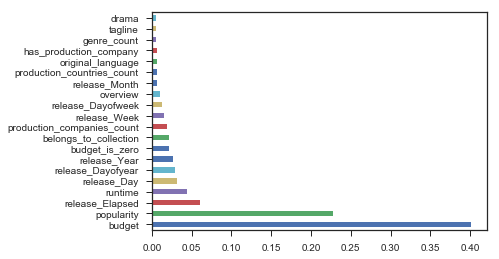

In [1985]:
fi.sort_values(ascending=False)[:20].plot('barh', legend=False)
plt.show()

# Scaling

In [1986]:
from sklearn.metrics import mean_squared_error

In [1991]:
test_df["release_Day"] = test_df["release_Day"].fillna(0)
test_df["release_Year"] = test_df["release_Year"].fillna(0)
test_df["release_Month"] = test_df["release_Month"].fillna(0)
test_df["release_Week"] = test_df["release_Week"].fillna(0)
test_df["release_Dayofweek"] = test_df["release_Dayofweek"].fillna(0)
test_df["release_Dayofyear"] = test_df["release_Dayofyear"].fillna(0)

In [2002]:
def train_test_rfr(train_df, test_df, y):
    
    #Separating the training features
    train_x = train_df.drop(y,1)
    train_y = train_df[y]
    ids = test_df["id"]
    test_x = test_df[train_x.columns]
    
    # Fit model using k nearest neighbors.
    rfr = RandomForestRegressor(n_jobs = -1, n_estimators= 20, min_samples_leaf= 5, max_features= 0.6)
    rfr.fit(train_x, train_y)
    predictions = rfr.predict(test_x)
    results = pd.DataFrame(predictions)
    ids = pd.DataFrame(ids)
    ids["revenue"] = results
    return ids

In [2003]:
results = train_test_rfr(train_df, test_df, "revenue")
results = results.rename(columns= {0:"revenue"})
results

,id,revenue
0,3001,14.520053
1,3002,13.443628
2,3003,15.541743
3,3004,14.729365
4,3005,12.973732
5,3006,13.820456
6,3007,14.337491
7,3008,17.426410
8,3009,16.869522
9,3010,19.395320


In [2004]:
results.to_csv("submission.csv", index = False)